In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.datasets import load_digits, load_iris, make_classification, make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"font.size": 14})

![Sometimes you just can't see the forest for the Decision Trees](https://pb-data-blogposts.s3.eu-central-1.amazonaws.com/effectiveness-of-decision-tree-ensembles/decision_tree_forest.png)
# Effectiveness of Decision Trees on real data

**TL;DR:** Decision Tree Ensembles like XGBoost and Random Forest consistently outperform other algorithms on real-world business data. I argue that this is largely due to their non-parametric decision functions based on discrete splits rather than distances in feature space, making them more robust to noise and outliers, while effectively capturing complex non-linear relationships and feature interactions.

### The Problem with real-world data
When I worked at an insurance company, developing machine learning models to predict customer churn and make product recommendations, I noticed an interesting trend: **decision tree ensembles** like [Random Forest](https://en.wikipedia.org/wiki/Random_forest) and [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) (e.g. [XGBoost](https://xgboost.readthedocs.io/), [CatBoost](https://catboost.ai/), [LightGBM](https://lightgbm.readthedocs.io/)) consistently outperformed other algorithms on real-world data. This wasn’t just a small edge in performance — these models seemed to thrive where others struggled, handling the complexities of business data much more effectively than alternatives like logistic regression, support vector machines (even with non-linear kernels), and simple neural networks (not taking into account modern nets more suitable for tabular data, like [NODE](https://arxiv.org/abs/1909.06312) or [TabNet](https://arxiv.org/abs/1908.07442)).

The key difference I observed between the datasets we used in the insurance industry and those often seen in academic exercises or machine learning competitions was the nature of real-world data, which was...well...kinda messy. Unlike carefully prepared, well-balanced datasets, real-world data had certain problematic characteristics that made many traditional algorithms perform quite poorly. These issues included:

- **Mostly tabular data**, inhomogeneously collected from various input sources like application databases and data warehouses.
- **Many categorical features**, often non-ordinal but still highly relevant.
- **Significant amounts of missing data**, requiring imputation strategies.
- **High levels of noise** in the data due to errors in data entry or obscure business logic embedded in ETL pipelines.
- **Skewed distributions** with relevant outliers that shouldn’t simply be discarded.
- **Feature correlation and collinearity**, sometimes strong, but not so strong that you'd just want to drop some of the features.
- **Class imbalances**, both in target variables and feature categories.

And I also had somewhat of an intuition that there were very relevant but small **pockets of relevant feature combinations** in the high-dimensional feature space, which contained just the information we needed for some edge-case predictions.

![Real-world data can be be a mess sometimes.](https://pb-data-blogposts.s3.eu-central-1.amazonaws.com/effectiveness-of-decision-tree-ensembles/messy_data.png)

### The strengths of Decision Tree Ensembles

Where traditional algorithms struggled with these challenges, **decision tree ensembles** handled them much more effectively. I believe this is largely due to the **non-smooth, non-parametric nature** of decision tree decision functions, which are based on discrete, hierarchical **splits** rather than smooth, parametrized functions sensitive to distances in feature space. They just don't make an assumption regarding the distribution of the data. This provides several advantages:

- **Robustness against noise**: Decision trees tend to ignore irrelevant noise by splitting only on the most informative features.
- **Handling of skewed distributions and outliers**: Trees can isolate outliers into their own branches without being negatively affected.
- **Capturing complex, non-linear relationships**: The hierarchical structure of trees allows them to model intricate interactions between features and the target variable.
- **Feature interaction and collinearity**: Decision trees can naturally capture correlations between features and are resilient to collinearity, as they split features independently and don't depend on a combination of coefficients across all features.
- **Native handling of categorical features**: Trees can create splits based on the category values, avoiding the need for complex and/or dimensionality-increasing preprocessing like one-hot encoding.
- **Handling of large and imbalanced datasets**: Ensemble methods scale well and can address class imbalances, especially with Gradient Boosting, where each estimator corrects errors from previous iterations, helping them pay more attention to harder-to-classify instances, often from minority classes.
- **Lower requirement for feature engineering**: The model makes fewer assumptions about the underlying data, reducing the need for manual feature engineering, which can be useful if the business logic generating the data is unclear and you don't want to let your potentially incorrect assumptions influence the model negatively.
- **Reduced overfitting through ensembling**: While individual decision trees are prone to overfitting, ensemble methods like Random Forests and Gradient Boosting combine many weak learners to improve generalization.

In short, many of the advantages of decision tree ensembles directly addressed the issues present in the real-world data I worked with.

Expressed in words, this is all you need to know. If you're convinced already, you can stop reading here. If you are, however, curious about understanding why what I mentioned above is the case, please keep reading. In the following, I will talk a bit more about how the decision functions of decision trees and provide some examples to for some of the points I mentioned above, and demonstrate their strengths.

### The Decision Function
Let's have a look at how tree models make their decisions. We'll take the CART algorithm (Classification and Regression Trees), as implemented in [scikit-learn](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) as an example (though there are other algorithms as well, e.g. [ID3](https://en.wikipedia.org/wiki/ID3_algorithm), [C4.5](https://en.wikipedia.org/wiki/C4.5_algorithm), [CHAID](https://en.wikipedia.org/wiki/Chi-square_automatic_interaction_detection)). We'll focus primarily on classification here. 

Decisions are made through a series of binary splits based on feature values. These splits are determined by finding the threshold that best separates the data at each node. The goal is to create homogeneous subsets with respect to the target variable. The tree is constructed by recursively splitting the data, and the decision function at each node is non-parametric, meaning it doesn’t rely on a fixed equation or coefficients as in linear models. The CART algorithm is used for both classification and regression tasks. The algorithm operates by selecting splits that minimize the impurity (or maximize the information gain) at each node, which leads to the following decision function:

$f(x) = \sum_{i=1}^{M} I(x \in R_{i}) * c_{i}$

Where $M$ is the number of terminal nodes (or leaves) in the tree, $I(x \in R_{i})$ is an indicator function that checks if the input feature $x$ falls within the region $R_{i}$, which corresponds to the terminal node $i$, and $c_{i}$ is the predicted outcome (e.g., class label or regression output) for all inputs that reach node $i$. You can see right away that there no parameters/coefficients that need to interact with the value of the features, it's just important weather the combination of features falls into the region of a particular terminal node or not.

So how does the algorithm decide what series of splits defines a terminal node's region in feature space? The CART algorithm makes splits in a way that tries to minimize a loss function during training, e.g. Gini impurity for classification or the mean squared error (MSE) for regression. Let's focus on classification here. The Gini impurity at a node $i$ is

$Gini(i) = 1 - \sum_{c=1}^{C} p_{c}^{2}$

Where $C$ is the total number of classes and $p_{c}$ is the proportion of samples of class $c$ at node $i$. You can see that the more samples of a class are at the node, the "cleaner" the split, the lower the impurity. At each split, the algorithm selects the feature and threshold within the feature that yield the lowest impurity (or highest information gain). It selects the split that best separates the classes from each other. And it keeps hierarchically adding more of these best splits, building a tree of splits until a stopping criterion (e.g. maximal depth of the tree) is met.

In the figure below, you can see how such a decision tree is created on the example of classifying the [Iris flower data set](https://www.kaggle.com/datasets/uciml/iris). You can see how each consecutive node makes a split on a given feature and threshold to separate the remaining data in the best possible way.

TODO: add decision tree graph viz of Iris here


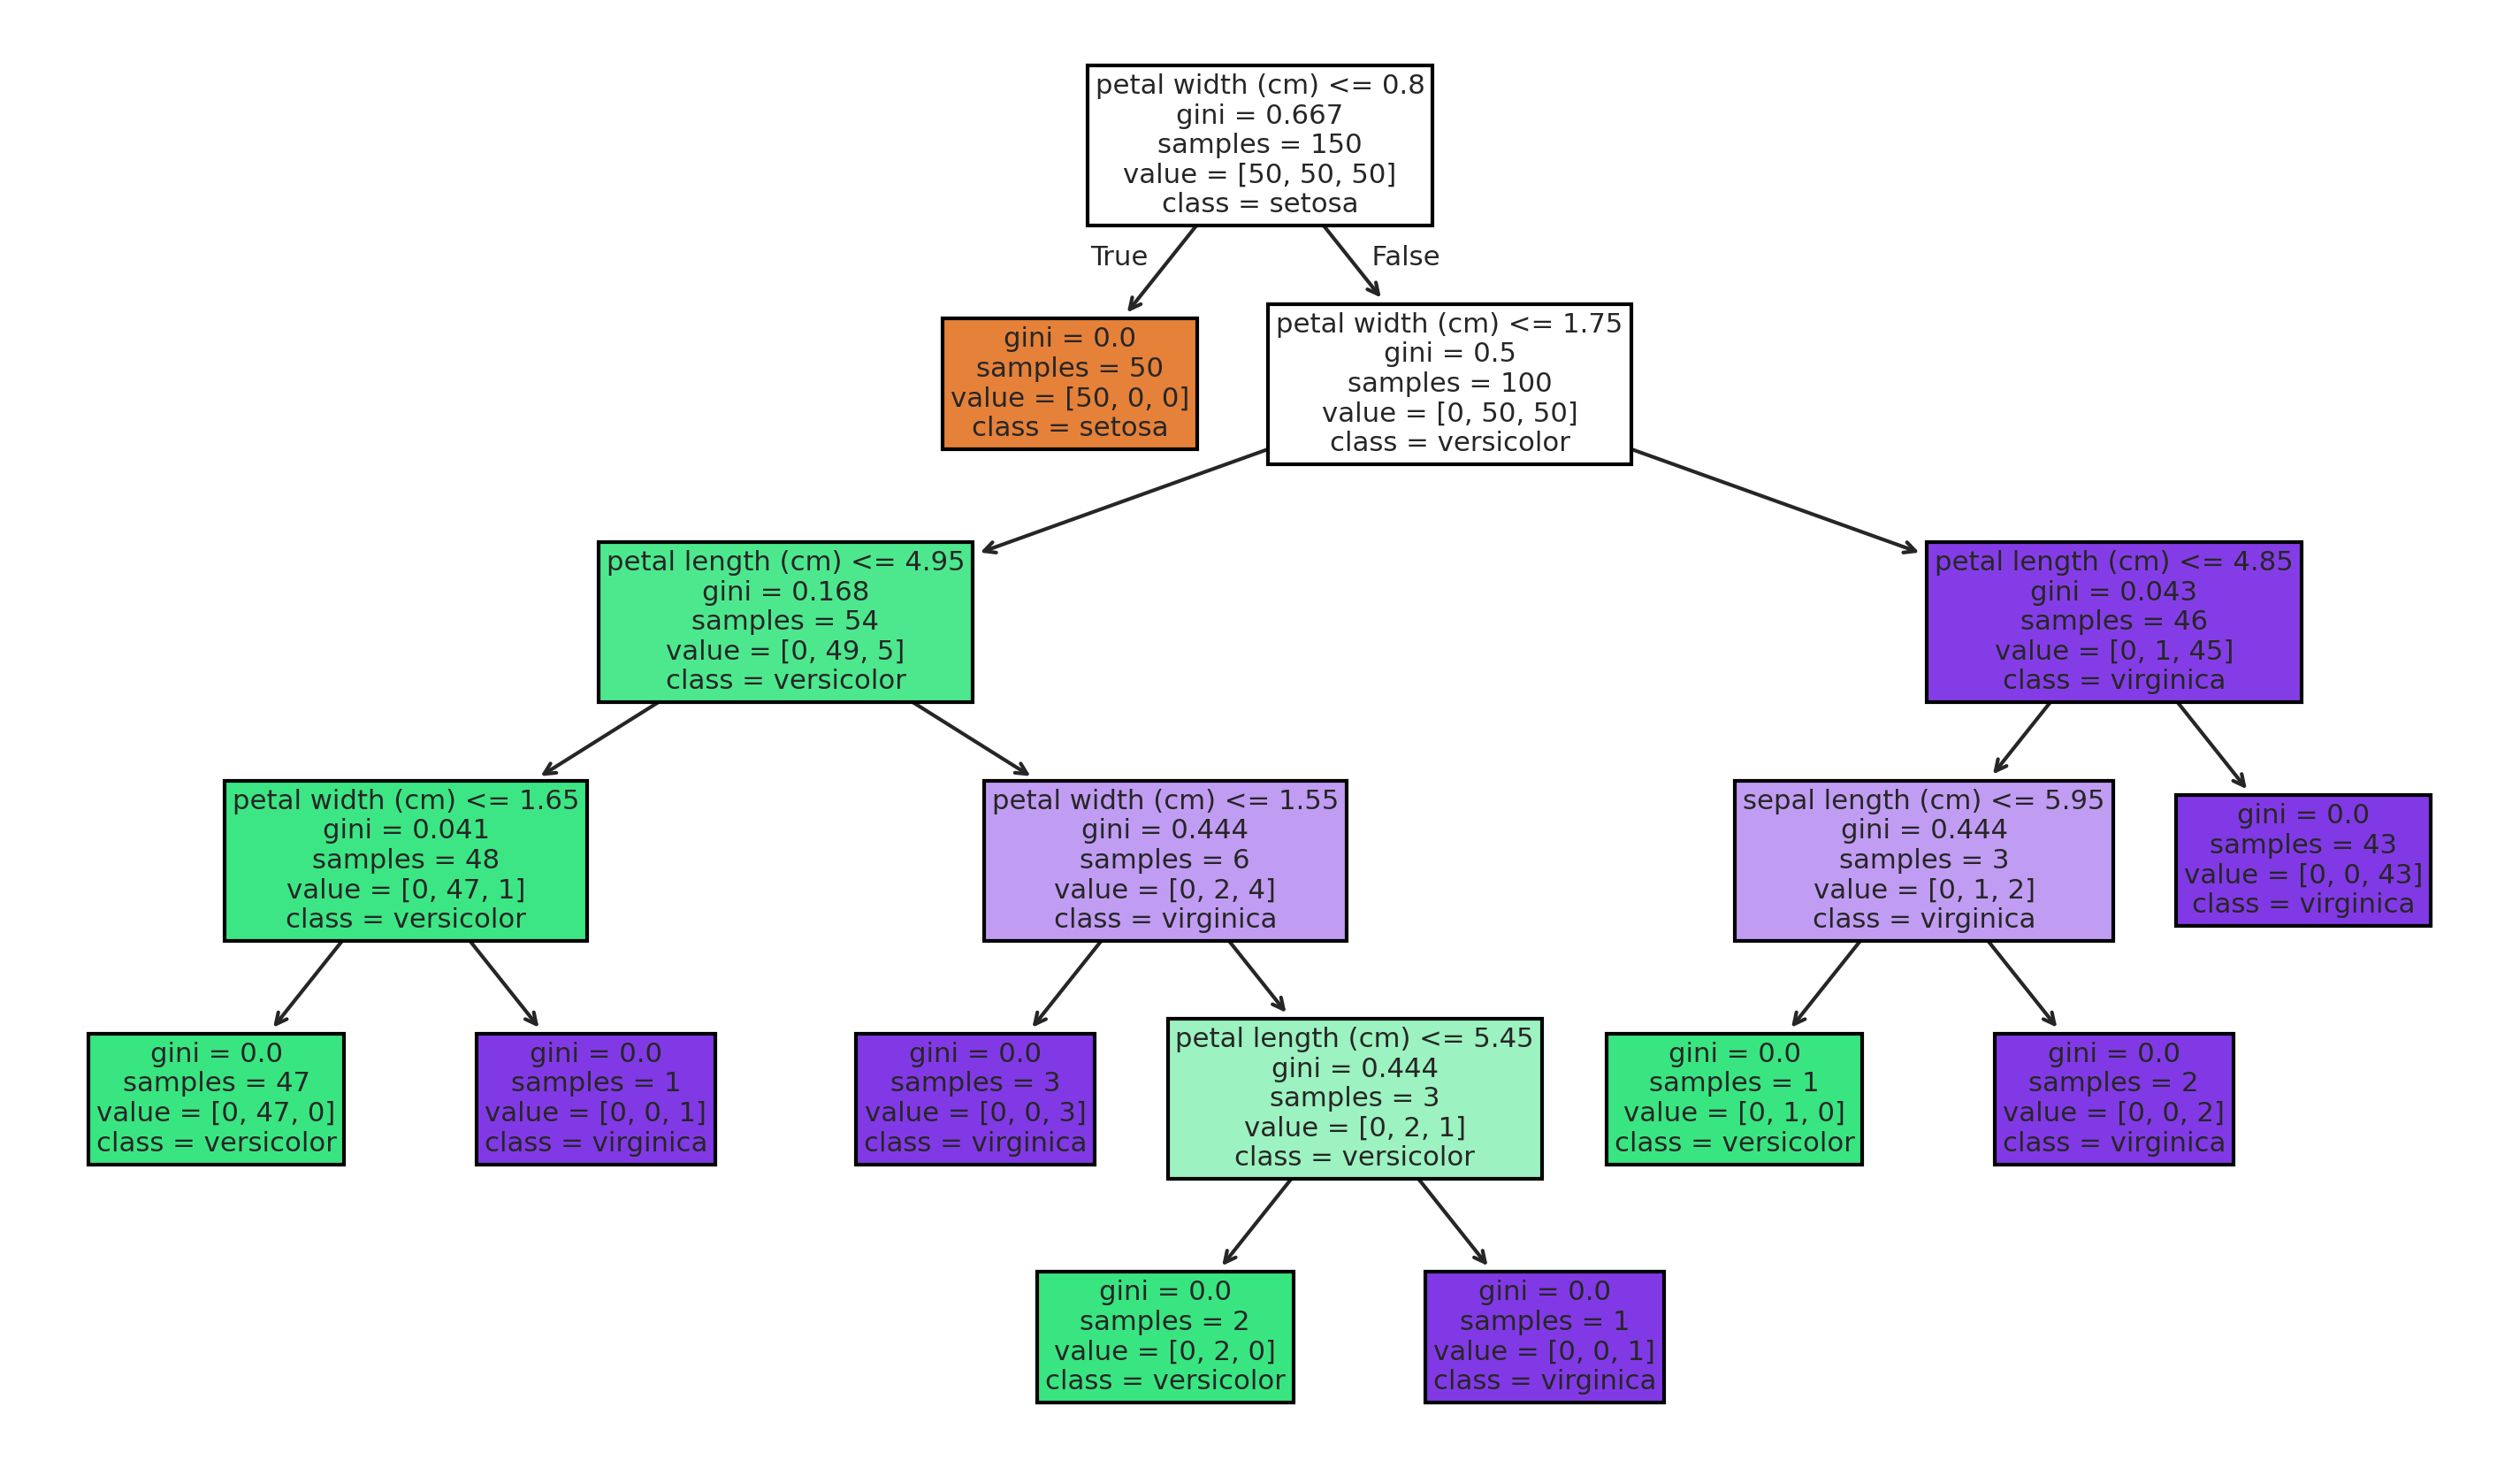

In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data[:, [0, 2, 3]]  # Select the sepal length, petal length, and petal width
y = iris.target

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X, y)

# plot graph of decision tree
plt.figure(figsize=(12, 7), dpi=300)
plot_tree(
    clf,
    feature_names=[iris.feature_names[0], *iris.feature_names[2:4]],
    class_names=iris.target_names,
    filled=True,
    impurity=True,
)
plt.savefig("plots/decision_tree_graph.png", dpi=300)
plt.show()

You can see how this behavior results in all the advantages we've discussed above. The resulting decision boundary is not constraint by a particular functional form, since with every new split, the decision boundary can "take a new direction" in the feature space. At which value the split threshold is set is only determined by which value results in the best class separation, not by how the feature values are distributed above or below the threshold. Basically, it can partition the feature space into arbitrarily shaped regions, which let's it deal with complicated non-linear relationships or non-ordinal categorical features. It deals with skewed distributions and outliers by isolating them into their own branches without affecting the rest of the model. It deals with noise or collinearity between features by simply ignoring them if those features don’t provide useful information for reducing impurity.

In the figure below, you can see a simple 3D example of how the feature spaces is divided into sharply cut regions that separate the different classes. One can see that the decision boundaries (meaning the boundaries beyond which the algorithm would predict one class or another) are not bound by a specific functional form, they can be cut however the algorithms finds it most effective.

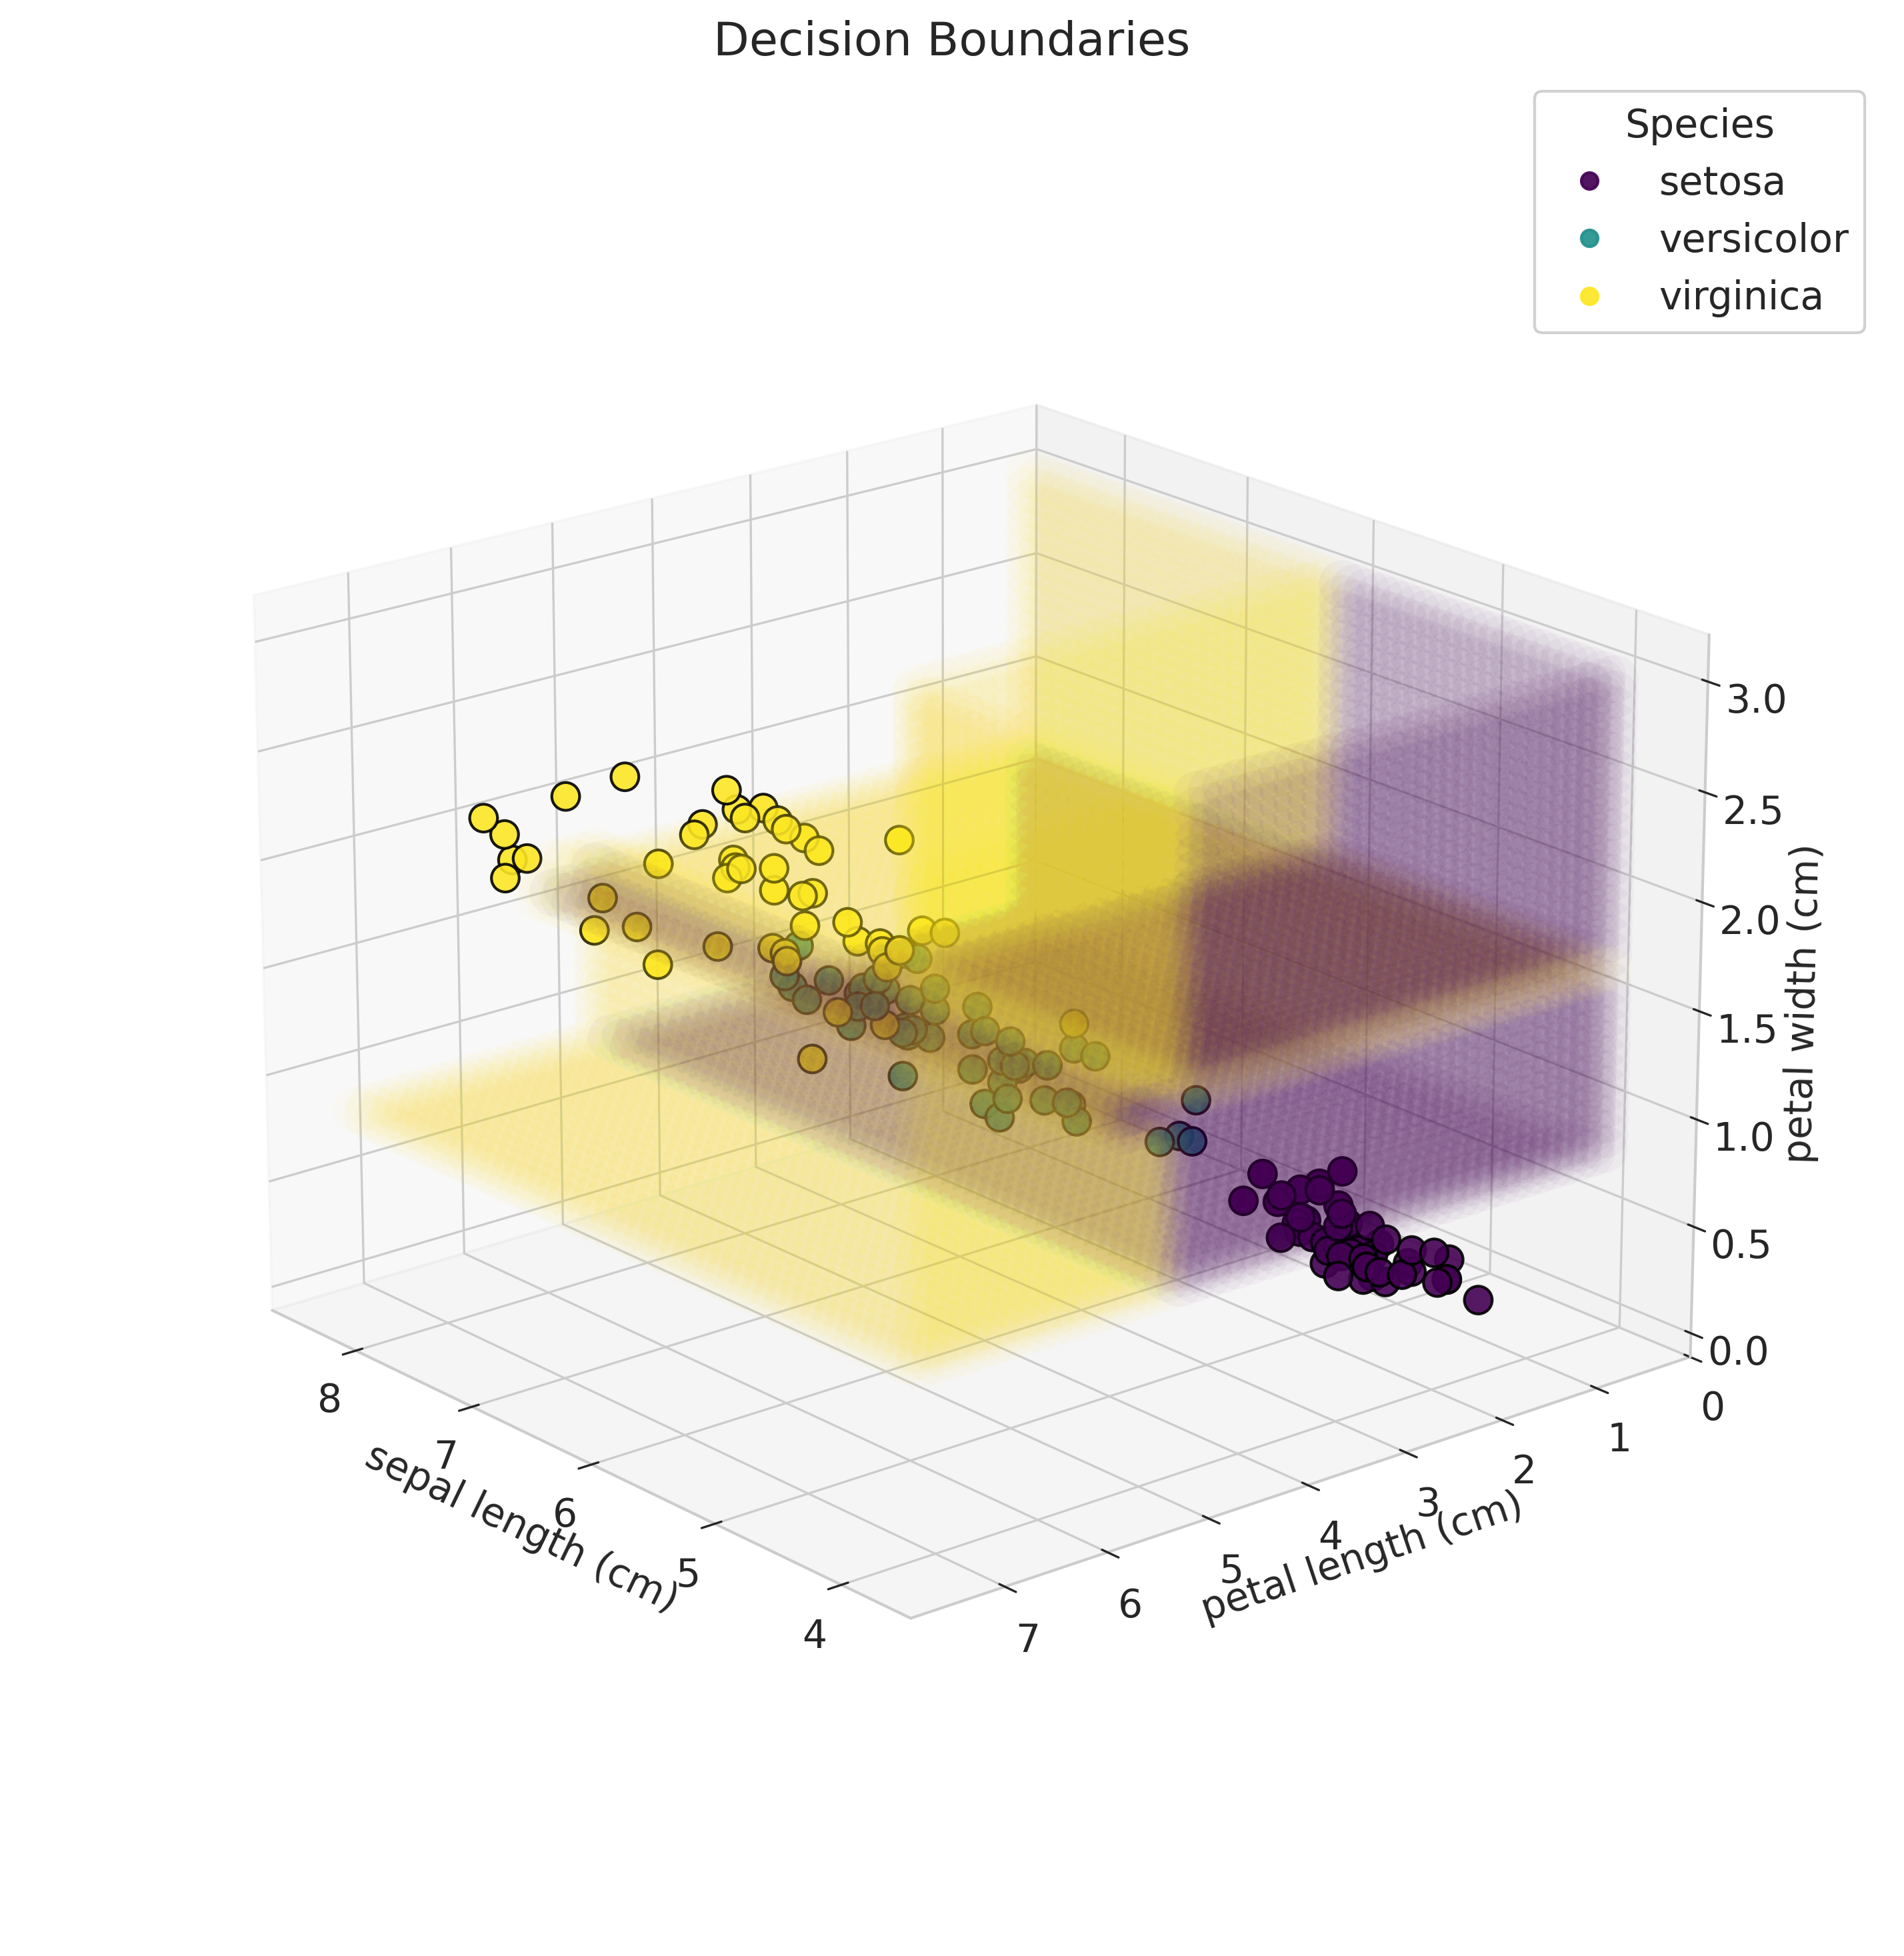

In [3]:
# Create a meshgrid to cover the 3D space
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
z_min, z_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5

xx, yy, zz = np.meshgrid(
    np.linspace(x_min, x_max, 50),
    np.linspace(y_min, y_max, 50),
    np.linspace(z_min, z_max, 50),
)

# Flatten the meshgrid for prediction
grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
predictions = clf.predict(grid).reshape(xx.shape)

# Compute the differences between neighboring predictions
dx = np.diff(predictions, axis=0, prepend=0)
dy = np.diff(predictions, axis=1, prepend=0)
dz = np.diff(predictions, axis=2, prepend=0)

# Create a mask to highlight the boundaries where the class changes
boundary_mask = (dx != 0) | (dy != 0) | (dz != 0)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10), dpi=300)
ax = fig.add_subplot(111, projection="3d")

# Highlight the boundary points where the class changes
ax.scatter(
    xx[boundary_mask],
    yy[boundary_mask],
    zz[boundary_mask],
    c=predictions[boundary_mask],
    cmap=plt.cm.viridis,
    alpha=0.03,
    s=300,
    edgecolor="none",
)

# Plot the actual data points
scatter = ax.scatter(
    X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.viridis, alpha=0.9, s=100, edgecolor="k"
)

# set perspective
ax.view_init(elev=20, azim=140)

# Set labels and title
ax.set_xlabel(iris.feature_names[0])  # Sepal length
ax.set_ylabel(iris.feature_names[2])  # Petal length
ax.set_zlabel(iris.feature_names[3])  # Petal width
ax.set_title("Decision Boundaries")
ax.set_box_aspect(None, zoom=0.85)

# Create a legend
legend = ax.legend(
    *scatter.legend_elements(), loc="upper right", title="Species", frameon=True
)
for i, label in enumerate(iris.target_names):
    legend.get_texts()[i].set_text(label)
ax.add_artist(legend)

plt.tight_layout()
plt.savefig("plots/tree_decision_boundaries.png", dpi=300)
plt.show()

### A Note on Overfitting
The discussion so far was only about a single decision tree. We could just keep growing the tree based on our training set until it perfectly covers every little edge-case in our training data, and classifies it perfectly. As you can imagine, it would probably generalize very poorly on new data that it hasn't seen during the training process - a phenomenon called overfitting. Combining many weak decision trees (of very limited size) into a large ensemble remedies this problem because each individual tree can't become complex enough to overfit as much, but combined together, they can still make strong predictions.

In the figure below, you can see how that works. We can see the learning curves (training & validation accuracy vs. number of training examples) of a single decision tree (on the left) vs. a Random Forest consisting of 300 Decision Trees (on the right). You can see that while both models achieve perfect accuracy on the training data, the single decision tree has a much worse validation accuracy, even when more training data is added. That is an indication that it overfits on the training data and does not generalize well to the validation data. For the Random Forest, this problem is much less pronounced.

In the following, let's deep-dive into a few of the advantages we've discussed so far and demonstrate them with code examples and visualizations.

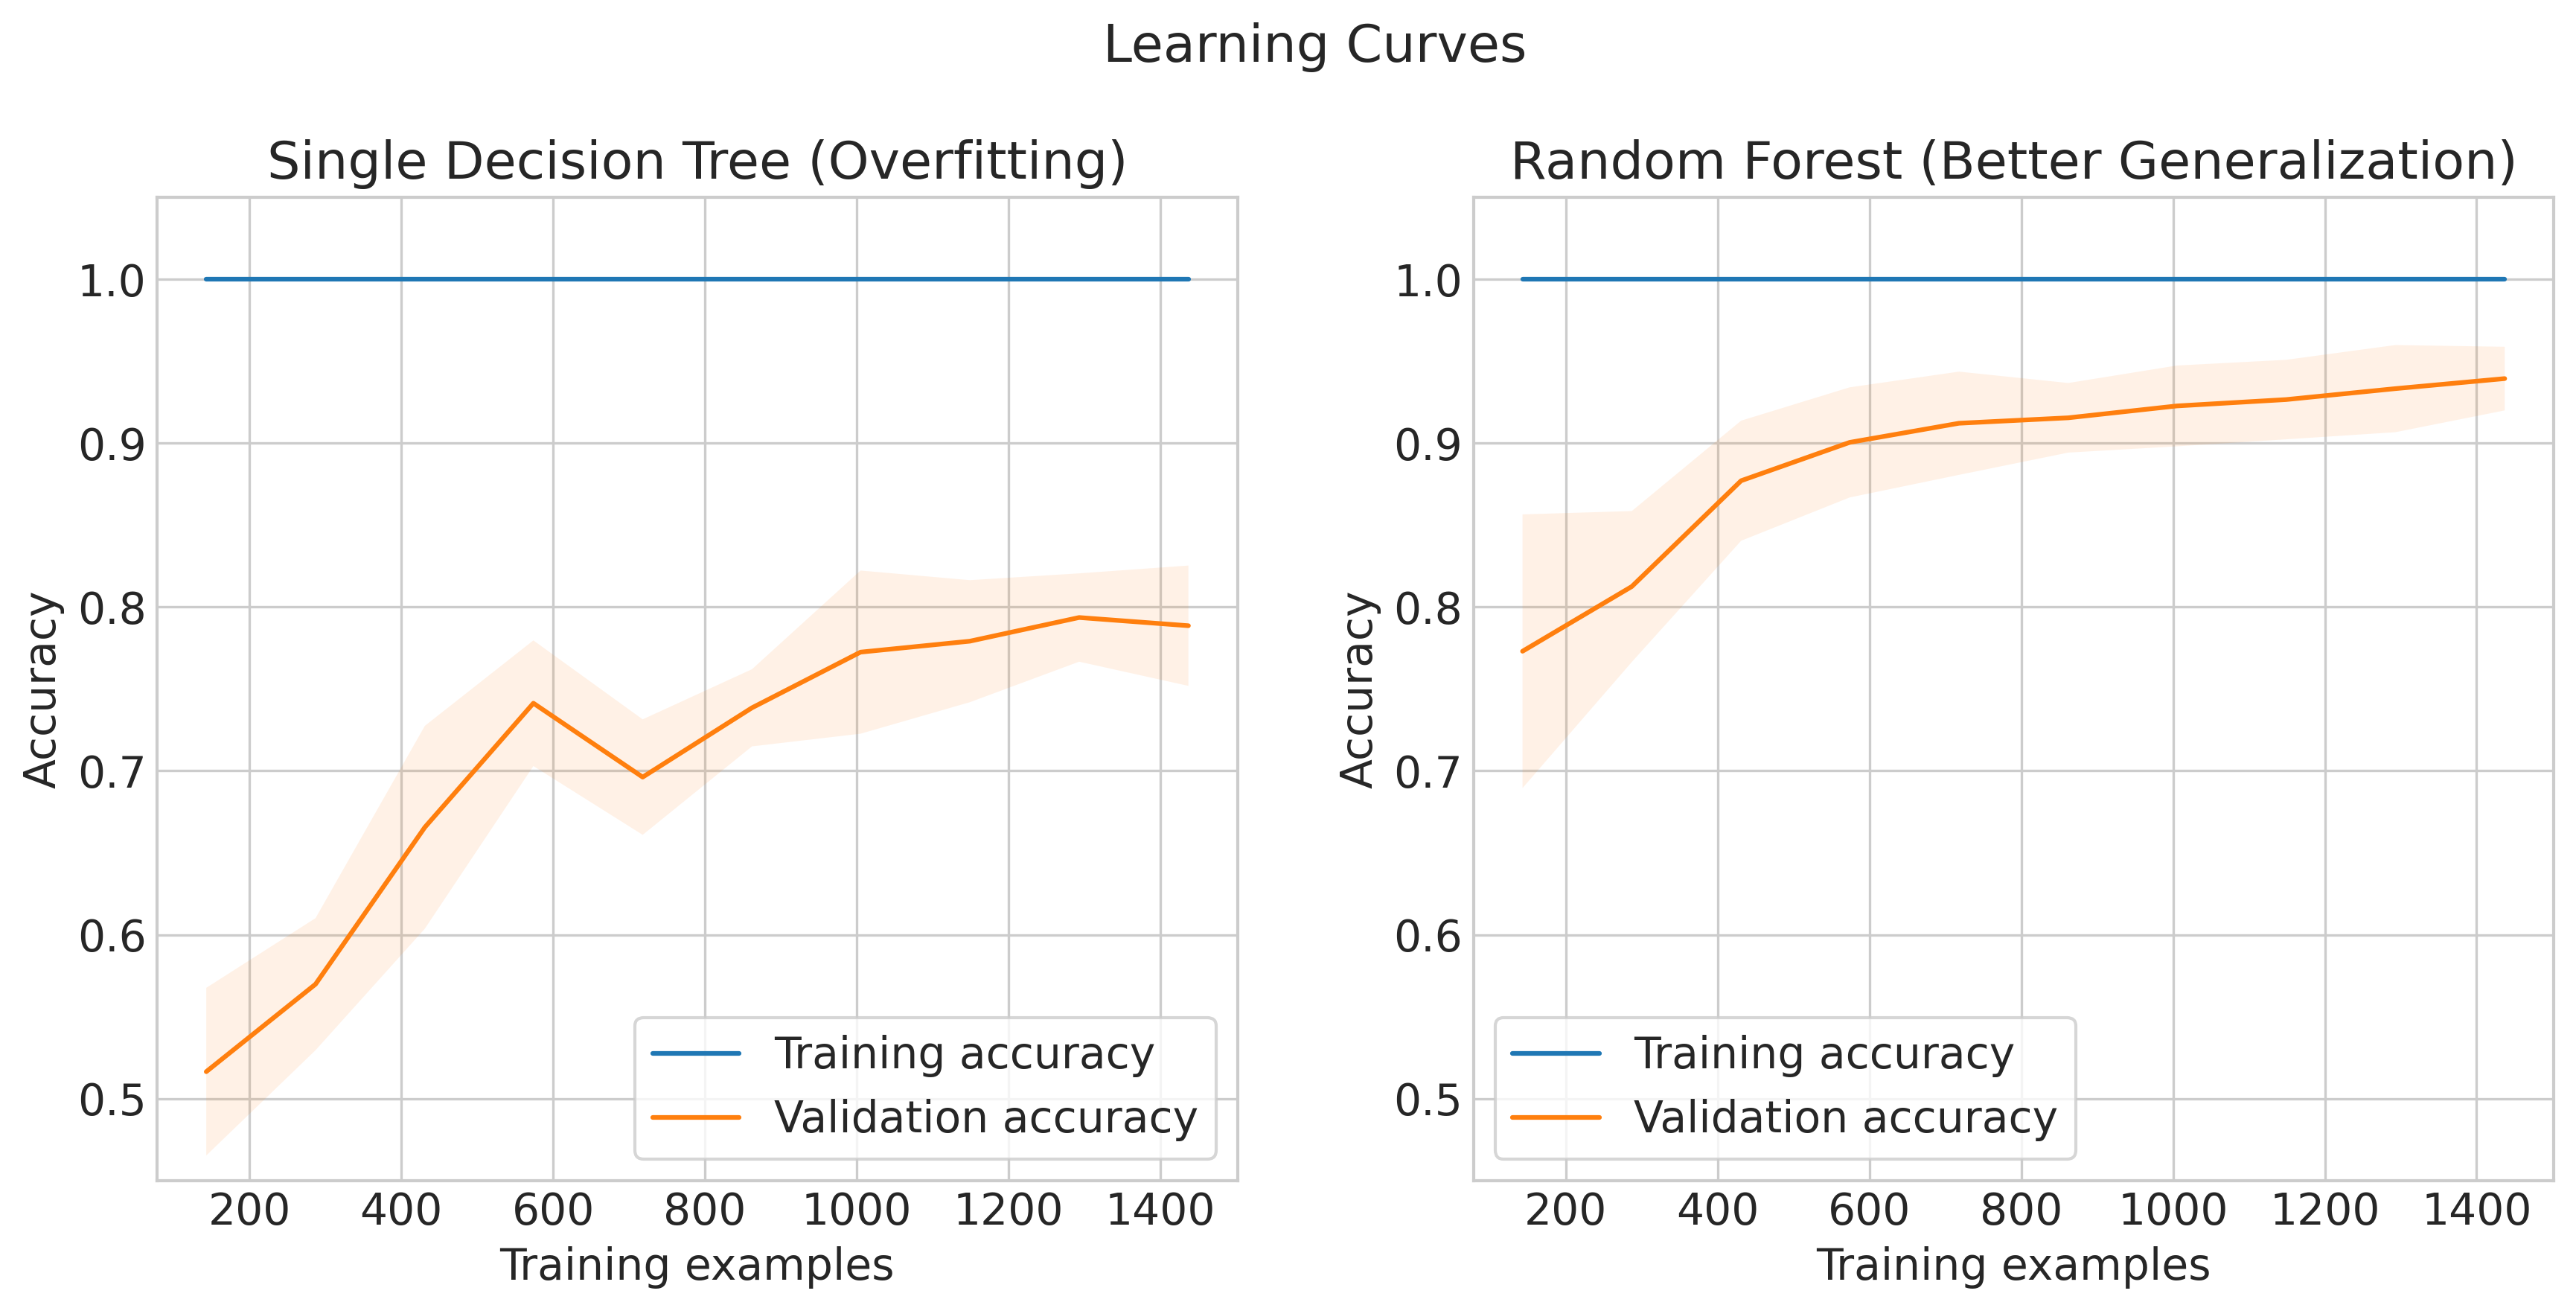

In [4]:
# Load the Iris dataset
digits = load_digits()
X, y = digits.data, digits.target


# Function to plot learning curves
def plot_learning_curves(estimator, X, y, title, ax):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X,
        y,
        cv=StratifiedKFold(n_splits=5),
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="accuracy",
    )

    # Compute mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curves
    ax.plot(
        train_sizes,
        train_mean,
        label="Training accuracy",
    )
    ax.plot(
        train_sizes,
        val_mean,
        label="Validation accuracy",
    )

    # Plot the standard deviation as a shaded area
    ax.fill_between(
        train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1
    )
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

    # Labels and title
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Accuracy")
    ax.legend(frameon=True)


# Initialize subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Plot learning curve for a single decision tree (which will overfit)
tree = DecisionTreeClassifier(max_depth=None, random_state=42)
plot_learning_curves(tree, X, y, "Single Decision Tree (Overfitting)", ax[0])

# Plot learning curve for a random forest (which generalizes better)
forest = RandomForestClassifier(n_estimators=300, random_state=42)
plot_learning_curves(forest, X, y, "Random Forest (Better Generalization)", ax[1])

ax[0].set_ylim(0.45, 1.05)
ax[1].set_ylim(0.45, 1.05)

fig.suptitle("Learning Curves")
plt.tight_layout()

# save the plot
plt.savefig("plots/learning_curve.png", dpi=300)
plt.show()

### Comparison of Decision boundaries with parametric models
Now, let's contrast this other models like logistic regression, support vector machines (SVMs), and neural networks, which rely on parametric decision functions. These models use a fixed mathematical form to map input features to output predictions. The "parameters" here are e.g. the coefficients in a logistic regression, the shape parameter in a SVM radial basis function kernel, or the weights in a neural network. To be fair, neural networks or SVM kernels like radial basis functions or polynomials can in theory approximate any continuous function for a given input range, but in practice, when training them with a finite amount of hyperparameters to tune, the particular mathematical form used by a model will still strongly determine how its decision boundaries are going to look like. This makes the encoding of complicated non-linear relationships much harder than with decision trees, and correlated features can distort the parameter estimates.

I'll try to demonstrate that in the figure below, simulating a binary classification problem (meaning there are only 2 classes, red and blue in the figure) with 2 feature which have a complex non-linear relationship with the target variable (the class). The data distribution doesn't follow a regular mathematical form, because I just drew it by hand. It should symbolize the notion of class "pockets" or "corridors" in feature space. Since the problem with only 2 classes and 2 features is a very simple one, we'll try to solve it with 4 very simple classifiers: A Random Forest with 30 trees, a Logistic Regression, a Support Vector Machine (SVM) with a 5th degree polynomial kernel and a Multi-Layer Perceptron (MLP) neural network with 2 hidden layers that each have 10 neurons.

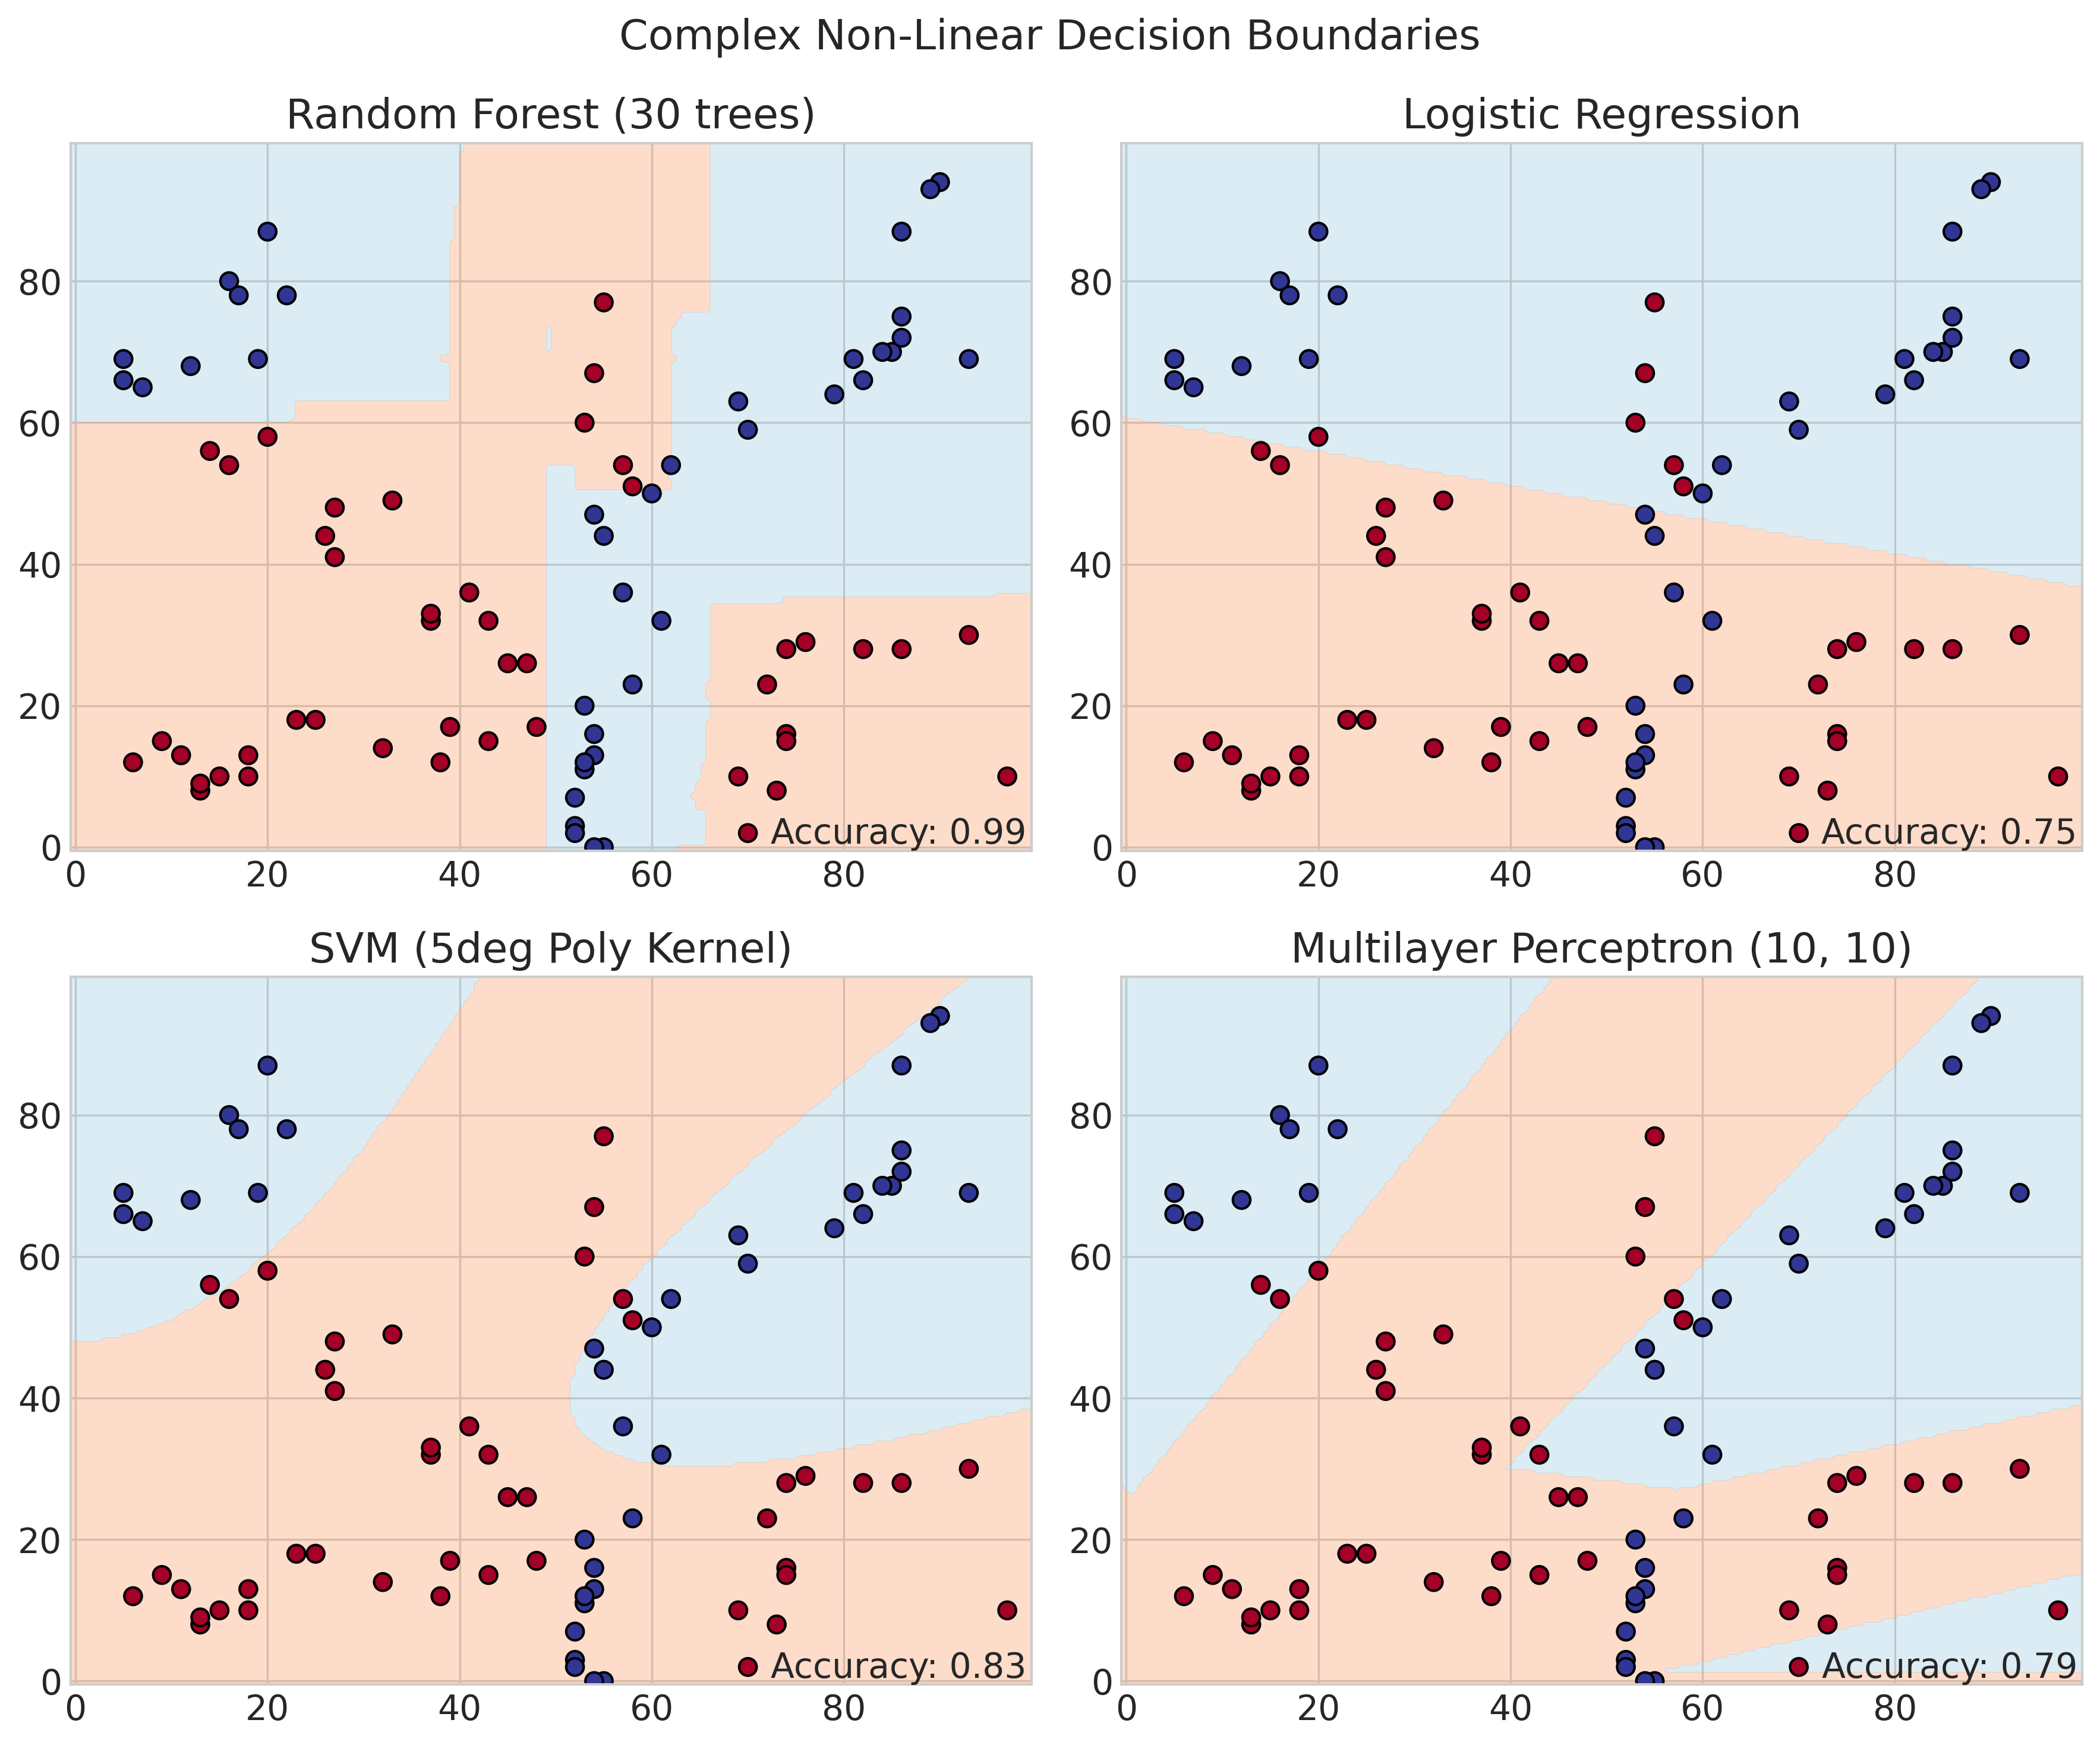

In [5]:
# load data
data = np.load("non-linear_data.npz")
X, y = data["X"], data["y"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Create classifiers
clf_rf = RandomForestClassifier(n_estimators=30, random_state=42)
clf_lr = LogisticRegression()
clf_svm = SVC(kernel="poly", degree=5, probability=True)
clf_mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1500, random_state=42)

# Train classifiers
clf_rf.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_mlp.fit(X_train, y_train)

# Create a meshgrid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))


# Function to plot decision boundaries
def plot_decision_boundary(ax, clf, title):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu, levels=1)
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolor="k", s=50
    )

    score = clf.score(X_test, y_test)
    ax.text(
        xx.max() - 0.5, yy.min() + 1, f"Accuracy: {score:.2f}", fontsize=14, ha="right"
    )
    ax.set_title(title)


# Plot decision boundaries
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

plot_decision_boundary(axes[0, 0], clf_rf, "Random Forest (30 trees)")
plot_decision_boundary(axes[0, 1], clf_lr, "Logistic Regression")
plot_decision_boundary(axes[1, 0], clf_svm, "SVM (5deg Poly Kernel)")
plot_decision_boundary(axes[1, 1], clf_mlp, "Multilayer Perceptron (10, 10)")

fig.suptitle("Complex Non-Linear Decision Boundaries")
plt.tight_layout()
plt.savefig("plots/non_linear_decision_boundaries.png", dpi=300)
plt.show()

As you can see, the Logistic Regression fails miserably, as it's a linear model and the relationship between the data and the class isn't linear at all. The SVM and MLP are a bit better at fitting to the data but also have trouble bending their functionally defined decision boundaries to the data. The Random Forest, however, can easily cut out the pockets and corridors that correctly classify the data as it can change the direction of its decision boundaries however it wants with every new split. To be fair, if I would have chosen more complex models, e.g. a SVM with a scaled radial basis function kernel or a MLP with more layers or more neurons per layer, they would also have done a good job at classifying the data. But since this is a very simple problem, I also want to keep the models simple to make my point. The Random Forest with only 30 trees is also relatively simple (in real-world problems often hundreds of tress are used) but it already does a very good job here.

### Influence of outliers
Parametric models are also heavily influenced by outliers because the entire dataset is used to optimize the parameters (rather than splitting on one feature threshold at a time as in decision trees). Outliers can skew the decision boundary, leading to poor generalization. For example, in SVMs, outliers near the decision boundary can drastically affect the placement of the support vectors, leading to overfitting. In a linear model, an outlier would pull the decision boundary away from where it should really be.

I tried to simulated such a situation in the figure below. This time I created some non-liner data that still has more or less clearly defined boundary. But then I also added some strong outliers for each class that lie on the wrong side of that boundary. We're again using the same classifiers as before: Random Forest, Logistic Regression, SVM, and MLP. You can see how Logistic Regression and the SVM fail to adjust their decision boundaries to the form of the data that is now distorted by the outliers. The MLP actually does a pretty good job at "cutting off" the outlier sections from the bulk of the data, but the Random Forest does an even better job at it, as its decision boundaries can change directions more flexibly.

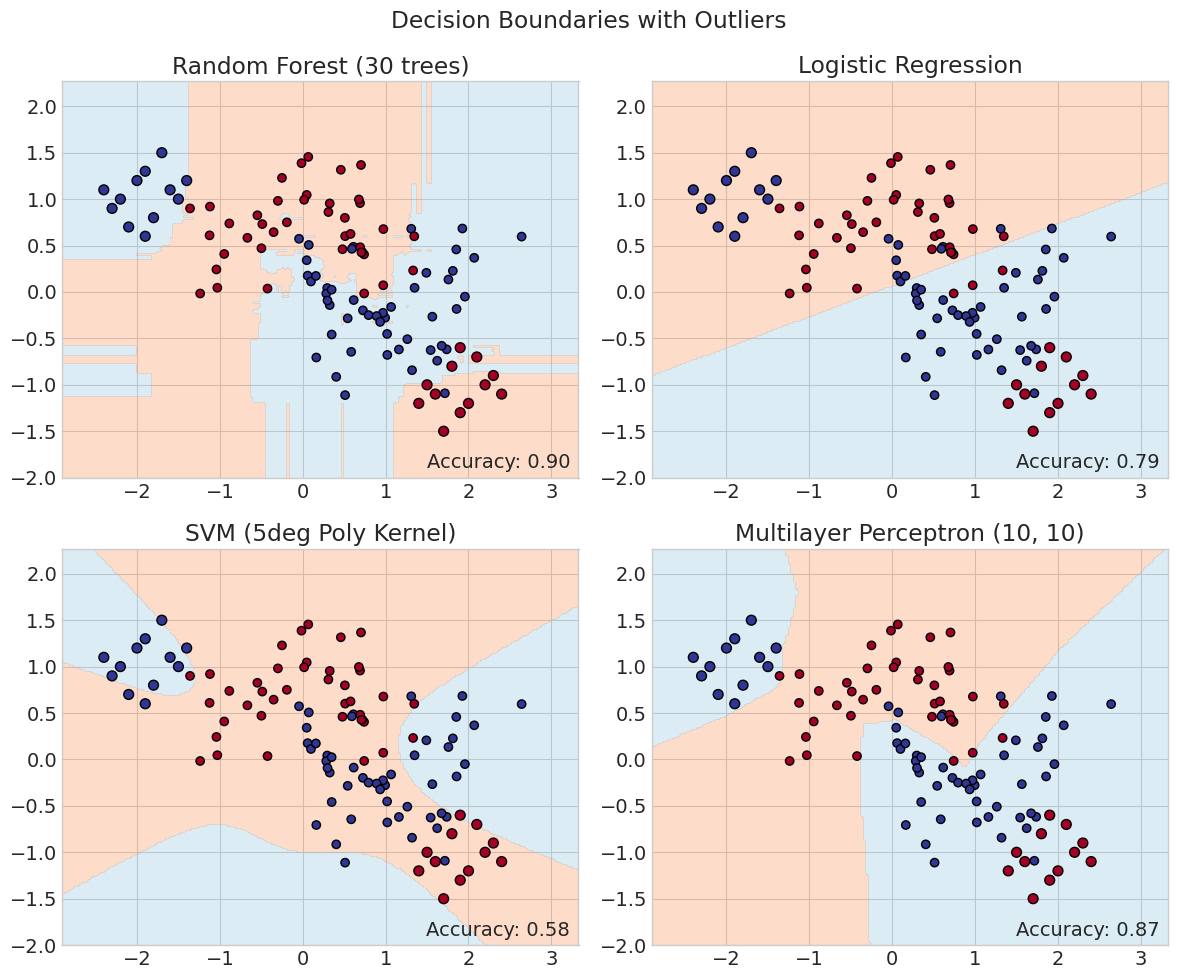

In [6]:
# Create a synthetic dataset with make_moons
X, y = make_moons(n_samples=300, noise=0.3, random_state=42)

# Introduce strong outliers in the "wrong" direction
outliers_class_0 = np.array(
    [
        [1.5, -1],
        [2, -1.2],
        [1.8, -0.8],
        [1.9, -1.3],
        [2.2, -1],
        [2.3, -0.9],
        [2.1, -0.7],
        [1.7, -1.5],
        [1.6, -1.1],
        [1.9, -0.6],
        [2.4, -1.1],
        [1.4, -1.2],  # More class 0 outliers on the class 1 side
    ]
)
outliers_class_1 = np.array(
    [
        [-1.5, 1],
        [-2, 1.2],
        [-1.8, 0.8],
        [-1.9, 1.3],
        [-2.2, 1],
        [-2.3, 0.9],
        [-2.1, 0.7],
        [-1.7, 1.5],
        [-1.6, 1.1],
        [-1.9, 0.6],
        [-2.4, 1.1],
        [-1.4, 1.2],  # More class 1 outliers on the class 0 side
    ]
)
outliers = np.vstack([outliers_class_0, outliers_class_1])
y_outliers = np.hstack(
    [np.zeros(len(outliers_class_0)), np.ones(len(outliers_class_1))]
)

# Add the outliers to the dataset
X = np.vstack([X, outliers])
y = np.hstack([y, y_outliers])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Create classifiers
clf_rf = RandomForestClassifier(n_estimators=30, random_state=42)
clf_lr = LogisticRegression()
clf_svm = SVC(
    kernel="poly",
    degree=5,
    probability=True,
)
clf_mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1500, random_state=42)

# Train classifiers
clf_rf.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_mlp.fit(X_train, y_train)

# Create a meshgrid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))


# Function to plot decision boundaries
def plot_decision_boundary(ax, clf, title):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu, levels=1)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolor="k")
    ax.scatter(
        outliers[:, 0],
        outliers[:, 1],
        c=y_outliers,
        cmap=plt.cm.RdYlBu,
        s=50,
        edgecolor="black",
    )  # Outliers

    score = clf.score(X_test, y_test)
    ax.text(
        xx.max() - 0.1,
        yy.min() + 0.1,
        f"Accuracy: {score:.2f}",
        fontsize=14,
        ha="right",
    )
    # tick width of 1
    ax.tick_params(width=1)
    ax.set_title(title)


# Plot decision boundaries for each classifier
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_decision_boundary(axes[0, 0], clf_rf, "Random Forest (30 trees)")
plot_decision_boundary(axes[0, 1], clf_lr, "Logistic Regression")
plot_decision_boundary(axes[1, 0], clf_svm, "SVM (5deg Poly Kernel)")
plot_decision_boundary(axes[1, 1], clf_mlp, "Multilayer Perceptron (10, 10)")

# Set title
fig.suptitle("Decision Boundaries with Outliers")
plt.tight_layout()
plt.savefig("plots/outlier_decision_boundaries.png", dpi=300)
plt.show()

### Influence of categoric variables
Furthermore, parametric models typically require that categorical features be encoded into numeric representations (e.g. label or one-hot encoding). For label encoding (just representing the classes/category values as consecutive numbers) the model would assume that the distances between the categories' values are meaningful. This can be problematic even for ordinal categories where the distance between values isn't really clear, and complete nonsense for non-ordinal categories where there's no meaningful distance between values. Non-ordinal categories can be one-hot encoded (creating a binary column for each category value), but this can introduce high-dimensionality and sparsity, especially with features that have many category values, making these models less efficient on such data (see [The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)).

To avoid dimensionality explosion, non-ordinal categories sometimes still have to be label-encoded. This is what I simulate in the figure below. We still have a binary classification problem with 2 features. One of the features is continuous and correlated with the class. But now the other one is a label-encoded, non-ordinal category. I synthesized that data by creating 10 categories (1 to 10), and then randomly assigning half of the categories with a higher probability to class red and the other half with a higher probability to class blue. This means that the numerical distance between these category values is not meaningful for predicting the class. However, it is very predictive if a data point is of a certain category or not. You can see in the figure how the Logistic Regression, SVM, and MLP don't do a great job at at representing this binary question of "is this data point of a certain category or not" and are rather confused by trying to assign meaning to the distance between the category labels, and fit their decision boundaries accordingly. The Random Forest, on the other hand, can just cut decision boundary corridors through the feature space that correspond very well to just picking a particular category value; hence, it performs much better at this classification with label-encoded non-ordinal categories.

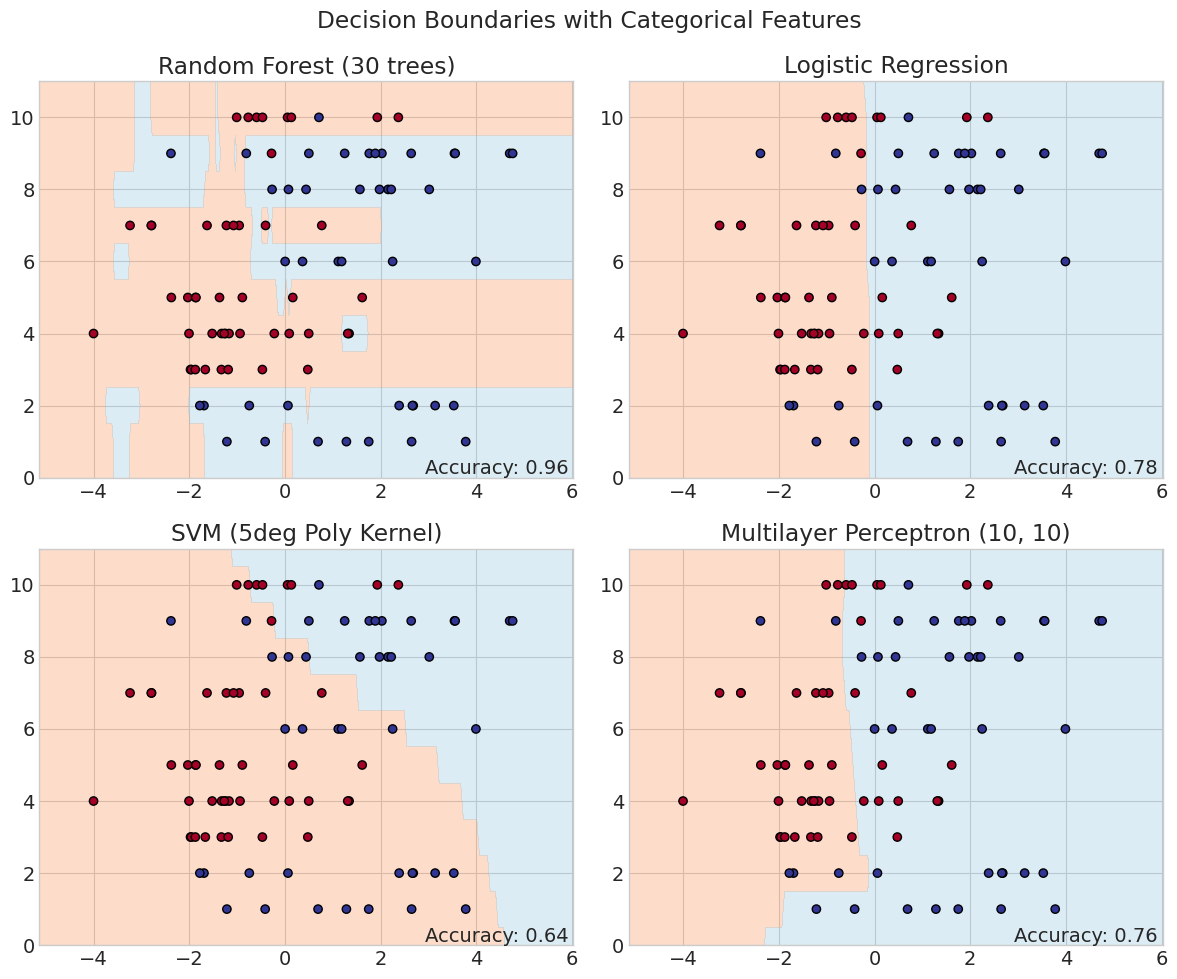

In [7]:
np.random.seed(42)

# Create a synthetic dataset with continuous and categorical features
X, y = make_classification(
    n_samples=300, n_features=2, n_informative=2, n_redundant=0, random_state=42
)

categories = np.arange(1, 11)
np.random.shuffle(categories)
X[y == 1, 1] = np.random.choice(
    categories,
    p=[0.19, 0.19, 0.19, 0.19, 0.19, 0.01, 0.01, 0.01, 0.01, 0.01],
    size=len(X[y == 1]),
)
X[y != 1, 1] = np.random.choice(
    categories,
    p=[0.01, 0.01, 0.01, 0.01, 0.01, 0.19, 0.19, 0.19, 0.19, 0.19],
    size=len(X[y != 1]),
)
X[:, 0] += 1.5 * np.random.randn(len(X))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Create classifiers
clf_rf = RandomForestClassifier(n_estimators=30, random_state=42)
clf_lr = LogisticRegression()
clf_svm = SVC(kernel="poly", degree=5, probability=True)
clf_mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1500, random_state=42)

# Train classifiers
clf_rf.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_mlp.fit(X_train, y_train)

# Create a meshgrid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = 0, 11
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
)


# Function to plot decision boundaries
def plot_decision_boundary(ax, clf, title):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu, levels=1)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolor="k")

    score = clf.score(X_test, y_test)
    ax.text(
        xx.max() - 0.1,
        yy.min() + 0.1,
        f"Accuracy: {score:.2f}",
        fontsize=14,
        ha="right",
    )
    ax.set_ylim(0, 11)
    ax.set_title(title)


# Plot decision boundaries for each classifier
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_decision_boundary(axes[0, 0], clf_rf, "Random Forest (30 trees)")
plot_decision_boundary(axes[0, 1], clf_lr, "Logistic Regression")
plot_decision_boundary(axes[1, 0], clf_svm, "SVM (5deg Poly Kernel)")
plot_decision_boundary(axes[1, 1], clf_mlp, "Multilayer Perceptron (10, 10)")

fig.suptitle("Decision Boundaries with Categorical Features")
plt.tight_layout()
plt.savefig("plots/categorical_decision_boundaries.png", dpi=300)
plt.show()

### Alternatives to Trees
There are none! All hail the mighty tree! JK, jokes aside, there are a couple of promising alternatives in the realm of neural networks. As we've seen in the examples above, the MLP was usually close behind the Random Forest in terms of performance, an could have easily performed even better if we would have made the model a bit more complex. Neural networks, with their large amount of parameters, can be very flexible and great at capturing complex relationships in data, though they're still less resilient to extreme noise and strongly skewed distributions. However, many of the neural networks used on tabular data often also kind of imitate the behavior of decision trees or even use decision trees directly. A few noteworthy mentions are:
- **[TabNet](https://arxiv.org/abs/1908.07442):** uses a combination of attention mechanisms and decision steps to learn from tabular features in a way that mimics decision trees.
- **[Neural Oblivious Decision Ensembles (NODE)](https://arxiv.org/abs/1909.06312):** each layer in NODE is composed of differentiable versions of decision trees, allowing it to learn hierarchical feature representations similar to how a decision tree would.
- **[DeepGBM](https://www.microsoft.com/en-us/research/uploads/prod/2019/08/deepgbm_kdd2019__CR_.pdf):** uses Gradient Boosting Machines (like LightGBM or XGBoost) to learn the initial data representations, and then feeds those into a neural network for further fine-tuning.

Also the Transformer architecture, which has been driving the development of large language models in recent years, has been tried out on tabular data. The **[Feature Tokenization Transformer (FT-Transformer)](https://arxiv.org/pdf/2106.11959)** uses self-attention mechanisms to learn from tabular data by encoding each feature as a token and applying attention to capture feature dependencies.

As is usual for large neural networks with complex architectures, these networks often need extensive tuning of hyperparameters and the training process itself to be trained well, and also require much more computational resources for doing so. And they still don't universally outperform Decision Tree Ensembles, which are typically easier to tune and train well and (of course, depending on the size) require less computational resources. Therefore, it is no surprise that Decision Tree Ensembles like XGBoost or Random Forests are still the quick-and-easy solution for a lot of messy, real-world tabular data.

### Conclusion
We've seen that in the context of real-world tabular data, decision tree ensembles like XGBoost and Random Forest consistently outperform other algorithms, especially when dealing with messy, complex datasets that contain noise, missing values, outliers, and a mix of categorical and continuous variables. Their non-parametric decision functions, based on discrete hierarchical splits rather than smooth mathematical functions, allow them to capture intricate non-linear relationships and feature interactions, while remaining robust against many of the common issues in real-world business data, such as class imbalance, highly skewed data distribution, feature collinearity, and high-cardinality categorical variables .

These ensembles are also highly effective in addressing the real-world challenges where traditional models like logistic regression, support vector machines, or even basic neural networks may struggle. However, as neural network models like TabNet and NODE continue to evolve, we now have some deep learning alternatives that can also compete in structured data environments. But for most applications involving complex, noisy, or imbalanced tabular data, decision tree ensembles remain a strong, reliable, interpretable, and relatively easy-to-use choice.

In [8]:
# APPENDIX
# Draw your own data

matplotlib.use("TkAgg")  # Use TkAgg for interactive plotting

# Initialize an empty canvas
canvas_size = (100, 100)  # Adjust the size of the canvas here
canvas = np.zeros(canvas_size, dtype=np.float32)  # Canvas starts as zeros (black)


# Function to update the canvas with mouse drawing
def on_mouse_move(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = int(event.xdata), int(event.ydata)
        if 0 <= x < canvas_size[1] and 0 <= y < canvas_size[0]:
            canvas[y, x] = 1  # Draw a white pixel where the mouse moves
            ax.imshow(canvas, cmap="gray")  # Update the canvas display
            fig.canvas.draw()


# Create a Matplotlib figure for drawing
fig, ax = plt.subplots()
ax.imshow(canvas, cmap="gray")
ax.set_title("Draw on the canvas (Close when done)")

# Connect the mouse motion event to the drawing function
fig.canvas.mpl_connect("motion_notify_event", on_mouse_move)

# Show the figure for drawing
plt.show()

# save data
with open("data.pkl", "wb") as f:
    pickle.dump(canvas, f)